# Генетические алгоритмы

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import math
import time

## Немного теории

**Генетические алгоритмы** (ГА) - это воплощение эволюционного подхода к ИИ, в котором мы применяем методы эволюции популяции для получения оптимального решения некоторой задачи. Придуманы в 1975 г. Джоном Холландом.

Для применения ГА необходимо:
 * Придумать алгоритм (способ) кодирования возможных решений задачи некоторыми векторами (**генами**) $g\in\Gamma$
 * На множестве генов $\Gamma$ определить **функцию приспособленности** (fitness function) $\mathrm{fit}: \Gamma\to\mathbb{R}$. Чем меньше эта функция, тем лучше решение.
 * Придумать механизм скрещивания двух генов, т.е. функцию $\mathrm{crossover}: \Gamma^2\to\Gamma$, и механизм мутации $\mathrm{mutate}: \Gamma\to\Gamma$. Как правило, эти функции представляют собой простые манипуляции векторами-генами.

Конкретные реализации ГА могут варьироваться от задачи к задаче, но в целом алгоритм такой:

1. Выбираем начальную популяцию $G\subset\Gamma$
2. Выбираем случайным образом текущую операцию: скрещивание или мутация
3. **Скрещивание**:
  * Выбираем случайным образом $g_1, g_2 \in G$
  * Вычисляем $g=\mathrm{crossover}(g_1,g_2)$
  * Если $\mathrm{fit}(g)<\mathrm{fit}(g_1)$ или $\mathrm{fit}(g)<\mathrm{fit}(g_2)$ - заменяем соответствующий ген в популяции на $g$.
4. **Мутация** - выбираем случайный ген $g\in G$ и заменяем его на $\mathrm{mutate}(g)$
5. Повторяем с шага 2, пока не получим достаточно маленькое значение функции $\mathrm{fit}$, или не исчерпаем число шагов.

Типовые решаемые задачи:
1. Составление расписаний
2. Оптимальная упаковка / нарезка на фигуры
3. Ускорение решения переборных задач
4. ...

## Пример 1: Задача о справедливом разделении клада

**Задача**: Двое путников нашли клад с алмазами разного размера (и, соответственно, разной стоимости). Необходимо разделить добычу поровну.

**Формальная постановка**: Есть множество чисел $S$. Необходимо разделить его на два подмножества $S_1$ и $S_2$, таких, что $\left|\sum_{i\in S_1}i - \sum_{j\in S_2}j\right|\to\min$.

In [2]:
N = 200
S = np.array([random.randint(1,10000) for _ in range(N)])
print(S)

[4400 8449 3594 7122 9936 5266 8379 8019 1942 3875 8130  891 5988 9783
   17 7753 8585 5156 9814 7417 7087 6919 2541 2399 2737 9607 7971 5431
 5679 9218 9047 5208 2930 3256 4361 1505 9935  755   74 4784 3561 4928
 3897 6943 4860 6843 6077 8016  202 4903  323 7904 3527 3636 8373 9744
 7812 6432 8622 2902  817 1096  613 5507 2644 6398 8206 2341 5086 8649
  699 1753  518 5692 8631 6674 9177 8596 6483 7547 3613 4714 2217 3973
 2833 5570   15 3145 5760 6724 5481 8747 8321 7571 4200 2817 2529 1900
 7909 8796 7169 6464 9612 8200 7200 2795 4321 6328 3351 5862 5003  163
 2747 3511 6955 7086 2828 9358 8922 9438 9705 6217 8773 2563 7170 4124
 9736 3317 7462  778 5461 8408 6872 4671 7501 1812 5289 5214 4085 7720
 3733 9149 4415 9643 5111 8659 6829 9560 9835 9553 5926 3781 6427 2583
 9892 6967 1977 4058 2773 4139 3673 8388 8858 7718 5635 1318 7581 2201
 4951 2092 3320 8886 1338 8725   69 5913 4665  896 1888 4996 4644 9129
 2282 3978  347 8117 1325  108 5364 6280 3401 1819 1629 4561 2458  175
 2807 

Будем кодировать возможное решение задачи двоичным вектором $B\in\{0,1\}^N$, где число, стоящее на $i$-ой позиции, будет показывать, какому из множеств ($S_1$ или $S_2$) принадлежит $i$-ое число в исходном списке. Для генерации таких случайных решений напишем функцию `generate`

In [3]:
def generate(S):
    return np.array([random.randint(0,1) for _ in S])

b = generate(S)
print(b)

[0 1 1 1 1 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 1 1 0 1 0 0 0 1 0 1 0 0 1 1 0 1 1
 0 1 0 0 0 1 0 1 0 0 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 1 1 1 0 1 0 0 1 1 1 0 1
 0 1 0 1 0 1 0 0 1 1 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 1 0 1 1 0
 1 1 0 1 1 0 1 1 1 1 0 1 1 0 1 1 0 0 1 1 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 0 1
 0 1 1 0 0 0 0 1 1 0 1 0 1 1 0 1 1 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 0 1 1 0 1
 0 0 1 1 0 1 1 1 1 0 0 1 1 0 0]


Опишем функцию `fit`, определяющую "стоимость" решения, т.е. разность между суммами элементов в двух множествах:

In [4]:
def fit(B,S=S):
    c1 = (B*S).sum()
    c2 = ((1-B)*S).sum()
    return abs(c1-c2)

fit(b)

13762

Опишем функции мутации и скрещивания

In [5]:
def mutate(b):
    x = b.copy()
    i = random.randint(0,len(b)-1)
    x[i] = 1-x[i]
    return x

def xover(b1,b2):
    x = generate(b1)
    return b1*x+b2*(1-x)

Создадим начальную популяцию решений

In [12]:
pop_size = 30
P = [generate(S) for _ in range(pop_size)]

In [13]:
def evolve(P,S=S,n=2000):
    res = []
    for _ in range(n):
        f = min([fit(b) for b in P])
        res.append(f)
        if f==0:
            break
        if random.randint(1,10)<3:
            i = random.randint(0,len(P)-1)
            b = mutate(P[i])
            i = np.argmax([fit(z) for z in P])
            P[i] = b
        else:
            i = random.randint(0,len(P)-1)
            j = random.randint(0,len(P)-1)
            b = xover(P[i],P[j])
            if fit(b)<fit(P[i]):
                P[i]=b
            elif fit(b)<fit(P[j]):
                P[j]=b
            else:
                pass
    i = np.argmin([fit(b) for b in P])
    return (P[i],res)

(s,hist) = evolve(P)
print(s,fit(s))

[1 0 1 1 1 1 0 0 0 0 0 1 1 0 0 1 1 0 1 1 0 0 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1
 0 0 1 0 0 0 1 1 1 1 0 1 0 1 1 0 0 1 0 0 0 0 1 0 1 1 1 0 0 0 1 0 0 1 0 0 1
 1 0 0 0 0 0 0 1 0 1 1 1 1 0 1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 1 1 0 1 0 0 0 1 1 1 0 0 1 1 0 0 1 0 0
 1 1 0 0 1 1 1 1 1 1 1 0 1 0 1 0 0 0 1 0 0 0 1 0 1 0 1 1 1 0 0 0 1 1 0 0 1
 1 0 0 0 1 1 1 0 1 0 0 1 1 1 1] 8


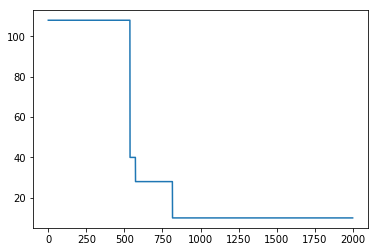

In [8]:
plt.plot(hist)
plt.show()

## Пример 2: Задача N ферзей

Необходимо расставить $N$ ферзей на шахматной доске размером $N\times N$ так, чтобы они не били друг друга.

Для начала приведём традиционное рекурсивное решение с помощью перебора с возвратом.

Положение ферзей на доске будем представлять списком $L$, где $i$-ое число - горизонтальная позиция ферзя в $i$-ой строке.

Наша задача будет найти первую из таких расстановок, после чего поиск можно будет прекратить. Вы сможете легко в качестве самостоятельного упражнения исправить решение, чтобы оно находило все расстановки.

In [14]:
N = 8

def checkbeats(i_new,j_new,l):
    for i,j in enumerate(l,start=1):
        if j==j_new:
            return False
        else:
            if abs(j-j_new) == i_new-i:
                return False
    return True

def nqueens(l,N=8,disp=True):
    if len(l)==N:
        if disp: print(l)
        return True
    else:
        for j in range(1,N+1):
            if checkbeats(len(l)+1,j,l):
                l.append(j)
                if nqueens(l,N,disp): return True
                else: l.pop()
        return False
            
nqueens([],8)


[1, 5, 8, 6, 3, 7, 2, 4]


True

In [15]:
%timeit nqueens([],20,False)

7.18 s ± 295 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Теперь решим ту же задачу с помощью генетического алгоритма. Приведённое решение частично вдохновлено [вот этой статьёй](https://kushalvyas.github.io/gen_8Q.html)

Будем представлять особей в виде описанных выше списков длины $N$, а в качестве минимизируемой функции будем рассматривать количество ферзей, бьющих друг друга в данной позиции. Опишем такую функцию `fit`:

In [16]:
def fit(L):
    x=0
    for i1,j1 in enumerate(L,1):
        for i2,j2 in enumerate(L,1):
            if i2>i1:
                if j2==j1 or (abs(j2-j1)==i2-i1): x+=1
    return x

Для ускорения вычислений, будем хранить в популяции списки вместе с их значениями fitness function. Сгенерируем начальную популяцию:

In [17]:
def generate_one(N):
    x = np.arange(1,N+1)
    np.random.shuffle(x)
    return (x,fit(x))

def generate(N,NP):
    return [generate_one(N) for _ in range(NP)]

generate(8,5)

[(array([1, 5, 3, 8, 2, 7, 6, 4]), 4),
 (array([6, 8, 2, 4, 1, 5, 7, 3]), 3),
 (array([7, 2, 3, 1, 6, 4, 5, 8]), 4),
 (array([5, 6, 4, 1, 8, 3, 7, 2]), 2),
 (array([3, 5, 2, 1, 8, 7, 4, 6]), 4)]

Определим функцию скрещивания и мутации. Скрещивание будет составлять потомка из двух частей, разрывая ген пополам в произвольной точке

In [18]:
def mutate(G):
    x=random.randint(0,len(G)-1)
    G[x]=random.randint(1,len(G))
    return G
    
def xover(G1,G2):
    x=random.randint(0,len(G1))
    return np.concatenate((G1[:x],G2[x:]))

xover([1,2,3,4],[5,6,7,8])

array([1., 2., 3., 4.])

Определим функцию выбора генов для селекции. Гены будут выбираться пропорционально их фитнесс-функции

In [19]:
def choose_rand(P):
    N=len(P[0][0])
    mf = N*(N-1)//2 # max fitness fn
    z = [mf-x[1] for x in P]
    tf = sum(z) # total fitness
    w = [x/tf for x in z]
    p = np.random.choice(len(P),2,False,p=w)
    return p[0],p[1]

def choose(P):
    def ch(w):
        p=[]
        while p==[]:
            r = random.random()
            p = [i for i,x in enumerate(P) if x[1]>=r]
        return random.choice(p)
    N=len(P[0][0])
    mf = N*(N-1)//2 # max fitness fn
    z = [mf-x[1] for x in P]
    tf = sum(z) # total fitness
    w = [x/tf for x in z]
    p1=p2=0
    while p1==p2:
        p1 = ch(w)
        p2 = ch(w)
    return p1,p2

Самая главная функция поиска решения:

In [20]:
mutation_prob = 0.1

def discard_unfit(P):
    P.sort(key=lambda x:x[1])
    return P[:len(P)//3]

def nxgeneration(P):
    gen_size=len(P)
    P = discard_unfit(P)
    P.extend(generate(len(P[0][0]),3))
    new_gen = []
    for _ in range(gen_size):
        p1,p2 = choose_rand(P)
        n = xover(P[p1][0],P[p2][0])
        if random.random()<mutation_prob:
            n=mutate(n)
        nf = fit(n)
        new_gen.append((n,nf))
        '''
        if (nf<=P[p1][1]) or (nf<=P[p2][1]):
            new_gen.append((n,nf))
        elif (P[p1][1]<P[p2][1]):
            new_gen.append(P[p1])
        else:
            new_gen.append(P[p2])
        '''
    return new_gen
    
def genetic(N,pop_size=100):
    P = generate(N,pop_size)
    mf = min([x[1] for x in P])
    n=0
    while mf>0:
        #print("Generation {0}, fit={1}".format(n,mf))
        n+=1
        mf = min([x[1] for x in P])
        P = nxgeneration(P)
    mi = np.argmin([x[1] for x in P])
    return P[mi]

genetic(8)

(array([2, 4, 6, 8, 3, 1, 7, 5]), 0)

In [21]:
%timeit genetic(10)

The slowest run took 84.07 times longer than the fastest. This could mean that an intermediate result is being cached.
7.67 s ± 12.2 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
import time
def measure(f,lo,hi):
    res = []
    for n in range(lo,hi):
        t = time.process_time()
        for _ in range(5):
            f(n)
        t = time.process_time()-t
        res.append((n,t/5))
    return res
n = measure(genetic,3,8)

## Задание: Решение Диофантовых уравнений

Задание вдохновлено [вот этим постом](https://habr.com/post/128704/). 

Диофантово уравнение - это уравнение с целочисленными корнями. Рассмотрим, например, уравнение
$$
a+2b+3c+4d=30
$$
Нам необходимо найти такие числа $a$,$b$,$c$,$d\in\mathbb{N}$, чтобы равенство выполнялось.

Подсказка 1: Можно рассматривать корни в диапазоне $[0,30]$

Подсказка 2: В качестве гена можно рассматривать список из значений корней

## Полезные ссылки

1. [Пример поиска кратчайшего пути между точками с помощью ГА](https://shra.ru/2016/12/geneticheskijj-algoritm-primer-primeneniya-metodiki/). Там же на сайте есть красивый пример анимации популяции алгоритма в процессе поиска пути.
2. [Генетический алгоритм применительно к строкам текста](https://habr.com/post/246951/)